In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load PNC dataset

import pickle
import numpy as np

dr = '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC2'
demo = pickle.load(open(dr + '/demographics.pkl', 'rb'))
rest = []
nback = []
emoid = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        r = np.load(f'{dr}/conn/{sub}_task-rest_fc.npy')
        r = remap(vec2mat(r))[a,b]
        rest.append(r)
    except:
        pass

rest = np.stack(rest)

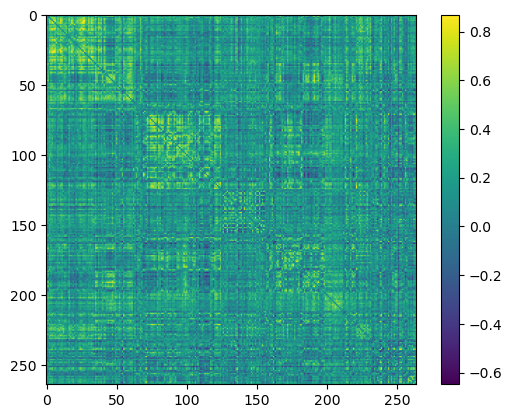

In [3]:
import matplotlib.pyplot as plt

plt.imshow(vec2mat(rest[0]))
plt.colorbar()
plt.show()

In [29]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        factor = 1
        bilinear = False
        n_classes = 264
        self.fc1 = nn.Linear(34716, 2000).float().cuda()
        self.fc2 = nn.Linear(2000, 264*30).float().cuda()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(x.shape[0], 264, 30)
        y = x
        sxy = torch.einsum('nat,nbt->nab', x, x)
        sxx = torch.einsum('nat,nat->na', x, x)
        sxy = torch.einsum('nab,na->nab', sxy, (1/sxx)**0.5)
        sxy = torch.einsum('nab,nb->nab', sxy, (1/sxx)**0.5)
        x = sxy[:,a,b]
        return x, y

net = Net()
optim = torch.optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-6)
x = torch.from_numpy(rest).float().cuda()

nepochs = 1000
pperiod = 50

for e in range(nepochs):
    optim.zero_grad()
    xhat, _ = net(x)
    loss = rmse(xhat, x)
    loss.backward()
    optim.step()
    if e % pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss)}')

print('Done')

0 0.4273
50 0.2156
100 0.2028
150 0.1924
200 0.1843
250 0.1755
300 0.1653
350 0.1563
400 0.1453
450 0.1388
500 0.132
550 0.1274
600 0.1194
650 0.1157
700 0.1126
750 0.1062
800 0.1025
850 0.1004
900 0.0968
950 0.0954
999 0.0932
Done


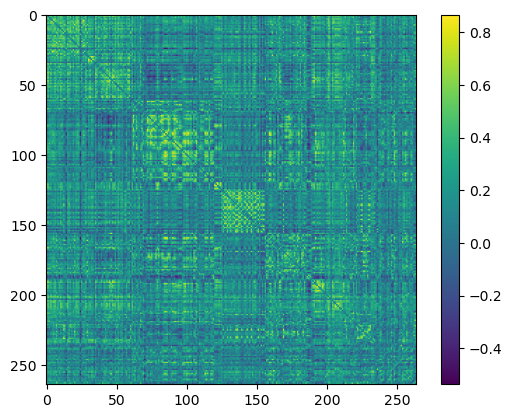

In [31]:
plt.imshow(vec2mat(x[2].detach().cpu().numpy()))
plt.colorbar()

In [32]:
with torch.no_grad():
    _, y = net(x)

y = y.detach().cpu().numpy()
print(y.shape)

(1387, 264, 30)


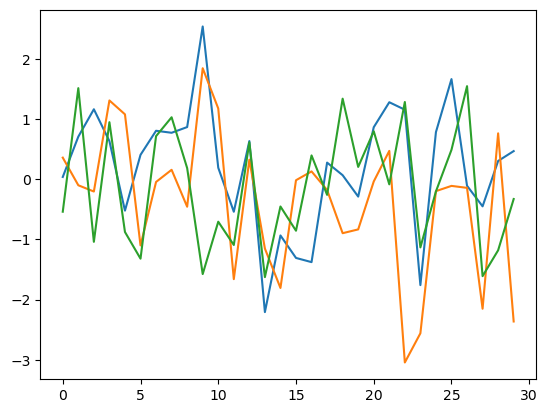

In [37]:
plt.plot(y[0,0:3].T)